# Image Classification with MNIST dataset
> NTNU CSIE Camp 2024

---

## MNIST 資料集
> [THE MNIST DATABASE](http://yann.lecun.com/exdb/mnist/)

由 70,000 張從 0 到 9 手寫數字灰階影像組成

以下是 MNIST 資料集包含的其中 40 張影像：

<img src="images/mnist.png" style="width: 600px;">

## 訓練及驗證資料與標籤

1. `x_train`：用於訓練神經網路的影像<br>
2. `y_train`：`x_train` 影像的正確標籤，用於評估模型在訓練過程中的預測表現<br>
3. `x_valid`：另外一組影像，用於驗證模型經過訓練後的效能<br>
4. `y_valid`：`x_valid` 影像的正確標籤，用於評估模型經過訓練後的預測表現<br>

**補充**
> + Definitions of Train, Validation, and Test Datasets
    + Training Dataset: The sample of data used to fit the model.
    + Validation Dataset: The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters. The evaluation becomes more biased as skill on the validation dataset is incorporated into the model configuration.
    + Test Dataset: The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.


> + 曾有書裡面是這麼說的
>   + Training set: A set of examples used for learning, that is to fit the parameters of the classifier.
>   + Validation set: A set of examples used to tune the parameters of a classifier, for example to choose the number of hidden units in a neural network.
>   + Test set: A set of examples used only to assess the performance of a fully-specified classifier.  
>
>   Brian Ripley, page 354, Pattern Recognition and Neural Networks, 1996

## 將資料載入

載入 MNIST 資料集

In [1]:
from tensorflow.keras.datasets import mnist

載入 MNIST 資料，資料已分割成影像和標籤，可用於訓練與驗證

In [2]:
# the data, split between train and validation sets
(x_train, y_train), (x_valid, y_valid) = mnist.load_data()

## 探索 MNIST 資料

In [3]:
x_train.shape # (筆數, 資料 x 軸像素, 資料 y 軸像素)

(60000, 28, 28)

In [4]:
x_valid.shape

(10000, 28, 28)

In [5]:
x_train.dtype

dtype('uint8')

In [6]:
x_train.min()

0

In [7]:
x_train.max()

255

In [8]:
x_train[0]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   3,
         18,  18,  18, 126, 136, 175,  26, 166, 255, 247, 127,   0,   0,
          0,   0],
       [  

**可以發現**
+ 影像本身是尺寸 28×28 的 2D 陣列
+ 介於 0 到 255 的 8 bits unsinged integer（正整數值）

Data 視覺化

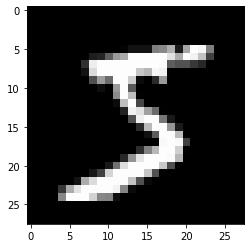

In [9]:
import matplotlib.pyplot as plt

image = x_train[0]
plt.imshow(image, cmap='gray')

上面的那張圖是多少？（看 `label`）

In [10]:
y_train[0]

5

## 資料前處理（Data Pre-processing）
> 準備資料以進行訓練
1. 扁平化（Flatten）影像資料，以簡化輸入至模型的影像資料。
2. 正規化影像資料，讓影像輸入數值具有相同的尺度，提升模型收斂速度與成效。
3. 分類標籤，讓標籤值無序數值化，調整成適合用於模型訓練的特徵空間。

**補充**  
> 了解更多關於基本資料前處理：https://medium.com/jameslearningnote/%E8%B3%87%E6%96%99%E5%88%86%E6%9E%90-%E6%A9%9F%E5%99%A8%E5%AD%B8%E7%BF%92-%E7%AC%AC2-4%E8%AC%9B-%E8%B3%87%E6%96%99%E5%89%8D%E8%99%95%E7%90%86-missing-data-one-hot-encoding-feature-scaling-3b70a7839b4a

### 扁平化（Flatten）影像資料

調整為連續像素的單一陣列

[
1 2 3 4 5 6 7 8 9 10
]


In [11]:
# Keras API Helper
x_valid_flatten = x_valid.reshape(10000, 784) # (資料筆數, 陣列長度)
x_train_flatten = x_train.reshape(60000, 784)

In [12]:
x_train_flatten.shape

(60000, 784)

In [13]:
x_train_flatten[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   3,  18,  18,  18,
       126, 136, 175,  26, 166, 255, 247, 127,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,  30,  36,  94, 154, 17

### 正規化影像資料
> Min-Max Normalization

將整數值轉換為介於 0 和 1 的浮點值

In [14]:
x_train_normalization = x_train_flatten / 255
x_valid_normalization = x_valid_flatten / 255 

In [15]:
x_train_normalization.dtype

dtype('float64')

In [16]:
x_train_normalization.min()

0.0

In [17]:
x_train_normalization.max()

1.0

### 分類編碼
> One Hot Encoding

舉例：
|實際數字| 是紅色嗎？| 是藍色嗎？| 是綠色嗎？|
|------------|---------|----------|----------|
|紅色|1|0|0|
|綠色|0|0|1|
|藍色|0|1|0|

也就是

```python
values = ['red, green, blue']
```

轉換為

```python
values = [
    [1, 0, 0],
    [0, 0, 1],
    [0, 1, 0]
]
```

**補充**  
> 其他情境下的 encoding 方式與優缺點：  
https://axk51013.medium.com/%E4%B8%8D%E8%A6%81%E5%86%8D%E5%81%9Aone-hot-encoding-b5126d3f8a63 

In [18]:
import tensorflow.keras as keras
num_categories = 10 # 有幾個類別

y_train_encoding = keras.utils.to_categorical(y_train, num_categories)
y_valid_encoding = keras.utils.to_categorical(y_valid, num_categories)

In [19]:
y_train_encoding[0:9]

array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

## 建立模型

1. 輸入層（Input Layer），負責接收某種預期格式的資料
2. 數個隱藏層（Hidden Layer），各由多個神經元（NN）組成。每個神經元都會依權重（Weight）影響到網路的猜測，權重值會隨著網路獲得效能和學習的回饋而在多次迭代中更新。
3. 輸出層（Output Layer），負責呈現網路對特定影像的猜測

### 具現化模型

In [20]:
from tensorflow.keras.models import Sequential

model = Sequential()

### 建立輸入層
+ 使用 Keras 的 Dense，其中的每個神經元及其權重，都會影響下一層的每個神經元。
+ 使用 `relu` 激活函數（Activation Function），使我們的 network 學會如何對資料進行更複雜的推測
+ `input_shape` 值會指定傳入資料的形狀
+ `unit` 引數（argument）為神經元數量

**補充**
> - NN 中 Weight 更新全中是如何運作的 👉[何謂 BP](https://medium.com/ai-academy-taiwan/back-propagation-3946e8ed8c55)
> - ACT 也就是所謂 Activation Function 是在做什麼 👉[何謂 ACT](https://medium.com/%E6%B7%B1%E6%80%9D%E5%BF%83%E6%80%9D/ml08-activation-function-%E6%98%AF%E4%BB%80%E9%BA%BC-15ec78fa1ce4)

In [21]:
from tensorflow.keras.layers import Dense

model.add(Dense(units=512, activation='relu', input_shape=(784,)))

### 建立隱藏層

In [22]:
model.add(Dense(units = 512, activation='relu'))

### 建立輸出層
+ 使用激活函數 `softmax`，這會使層中每一個值成為介於 0 和 1 的機率（加總值為 1）

In [23]:
model.add(Dense(units=10, activation='softmax'))

### 總結模型
模型的摘要

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               401920    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 10)                5130      
                                                                 
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________


**補充**
> - Hyperparameter, Parameter...?
>   - Hyperparameter: A hyperparameter is a variable that is set before the training process begins. They control the learning process and determine the values of model parameters that a learning algorithm ends up learning. For example, learning rate, batch size and choice of activation function are hyperparameters.
>   - Parameter: A parameter is a variable that is learned from the data during the training process. It is used to represent the underlying relationships in the data and is used to make predictions on new data. For example, in a neural network, the weights and biases are parameters.

### 編譯模型

In [25]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'])

## 訓練模型
+ **觀察準確度**
  + 從 `accuracy` 可以看出模型在這個 Epoch 對所有訓練資料的表現如何
  + 從 `val_accuracy` 可以看出模型在驗證資料上的表現

In [26]:
history = model.fit(
    x_train_normalization, 
    y_train_encoding, 
    validation_split = 1, 
    epochs=5, 
    verbose=1, 
    #batch_size=10,
    validation_data=(x_valid_normalization, y_valid_encoding) 
)

Epoch 1/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.1889 - accuracy: 0.9426 - val_loss: 0.1430 - val_accuracy: 0.9596
Epoch 2/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0842 - accuracy: 0.9764 - val_loss: 0.0865 - val_accuracy: 0.9765
Epoch 3/5
1875/1875 [==============================] - 14s 7ms/step - loss: 0.0599 - accuracy: 0.9833 - val_loss: 0.0816 - val_accuracy: 0.9806
Epoch 4/5
1875/1875 [==============================] - 16s 8ms/step - loss: 0.0458 - accuracy: 0.9869 - val_loss: 0.0942 - val_accuracy: 0.9791
Epoch 5/5
1875/1875 [==============================] - 14s 8ms/step - loss: 0.0372 - accuracy: 0.9898 - val_loss: 0.1090 - val_accuracy: 0.9770


繪製圖表觀察每個 epoch 對應的 model accuracy

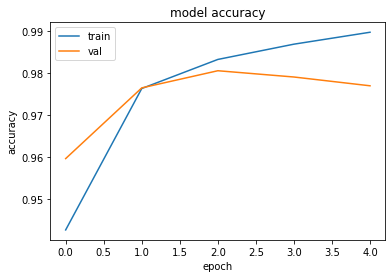

In [27]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

繪製圖表觀察每個 epoch 對應的 model loss


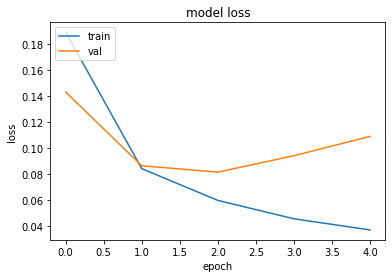

In [28]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

繪製 Confusion Matrix 觀察模型在各個類別的預測表現

313/313 [==============================] - 1s 2ms/step


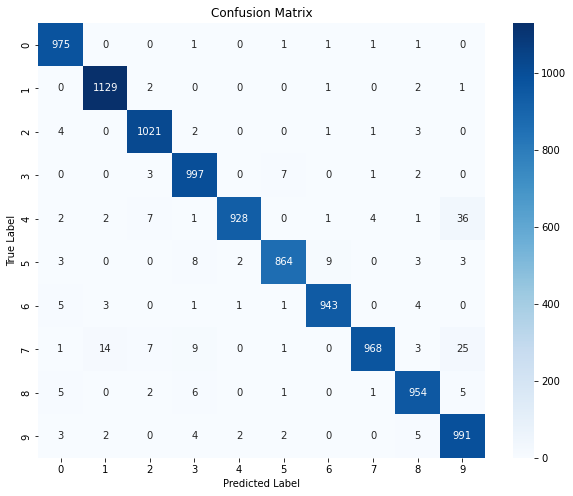

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(x_valid_normalization)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_valid_encoding, axis=1)

conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

class_labels = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

**補充**
- fit(train) model vs. tune model?
  - fit(train) model: Training refers to the process of using a machine learning algorithm to learn the relationship between input data and the corresponding target outputs.
  - tune model: Tuning refers to the process of adjusting hyperparameters of a machine learning model to improve its performance. 

## 使用模型

### 儲存模型

In [ ]:
model.save("model/mnist.h5")

### 載入模型

In [ ]:
model_load = keras.models.load_model("model/mnist.h5")
model_load.summary()

### 預測圖像
先拿資料集當中的圖片來試試

查看圖像

In [ ]:
image = x_valid[2024]
plt.imshow(image, cmap='gray')

查看圖像的資料型態

In [ ]:
predict_img_origin = x_valid[2024]
print(f"這張圖片的資料尺寸：{predict_img_origin.shape}")
print(f"這張圖片的資料型態：{predict_img_origin.dtype}")

圖像資料前處理

In [ ]:
predict_img = (predict_img_origin/255).reshape(1,784).astype("float32")
predict_img

預測圖像

In [ ]:
import numpy as np

predictions = model_load.predict(predict_img)
predicted_classes = np.argmax(predictions, axis=1)

print(f"預測結果數值：{predictions}")
print(f"預測的結果類別：{predicted_classes}")

### 預測自己拍攝的圖像

載入與查看原始圖片

In [ ]:
from PIL import Image, ImageOps
from matplotlib import pyplot as plt

image_dir = 'images/two_yellow_bg.jpg' # six_blue_bg.jpg
image = Image.open(image_dir)
# 如果圖片讀取後方向不對，可以用下面這行解決
# image = image.transpose(Image.ROTATE_270)

plt.imshow(image)
plt.axis('off') # 不顯示座標軸
plt.show()

將圖像前處理

In [ ]:
import cv2
import numpy as np

image = cv2.imread(image_dir)
image_resized = cv2.resize(image, (28, 28)) #調整長寬 px
image_gray = cv2.cvtColor(image_resized, cv2.COLOR_BGR2GRAY) #轉換成灰階

plt.imshow(image_gray, cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
def check_backgroud_black(lst):
    count = sum(1 for color_code in lst if color_code < 100)
    return count >= 3

#以三個角落（背景）來認定圖片是否需要反轉色彩
four_corner = [image_gray[2, 4], image_gray[2, 25], image_gray[25, 2], image_gray[25, 25]]
if check_backgroud_black(four_corner) == True:
    predict_img = (image_gray/255).reshape(1,784).astype('float32')
else:
    inverted_image = cv2.bitwise_not(image_gray)
    plt.imshow(inverted_image, cmap='gray')
    plt.axis('off')
    plt.show()
    predict_img = (inverted_image/255).reshape(1,784).astype('float32')

預測圖像

In [ ]:
predictions = model_load.predict(predict_img)
predicted_classes = np.argmax(predictions, axis=1)

print(f"預測結果數值：{predictions}")
print(f"預測的結果類別：{predicted_classes}")